In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib
import decimal
from matplotlib import pyplot as plt
from matplotlib import font_manager
from matplotlib.colors import LogNorm

In [134]:
def custom_round(x, base):
    return base * int(decimal.Decimal(float(x)/base).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP)) if not pd.isna(x) else x


def plot_pie_chart(csv_pd, question_list,  header):
    faculty_col = (6-csv_pd[header])
    faculty_col = pd.Series(faculty_col.apply(lambda x: custom_round(x, base=0.5)))
    faculty_dict = dict()

    # plot pie chart
    for i in faculty_col:
        if not pd.isna(i):
            if i in faculty_dict:
                faculty_dict[i] += 1
            else:
                faculty_dict[i] = 1
                
    sum_of_response = 0
    for key in faculty_dict:
        sum_of_response += faculty_dict[key]
    plt.pie([float(faculty_dict[v]) for v in faculty_dict], labels=[str(k) for k in faculty_dict], autopct='%1.2f%%')

    plt.title(label=question_list[csv_pd.columns.get_loc(header)], fontsize="14", fontstyle='italic')
    plt.savefig("filename.png", dpi=800)
    plt.show()
    print(sum_of_response)
    print(faculty_dict)

In [140]:
def cal_corelation(numeric_csv_file, title1, title2, question_list):
    temp_df = numeric_csv_file[numeric_csv_file[title1].notna() & numeric_csv_file[title2].notna()]
    correlation = temp_df[title1].corr(temp_df[title2])
    return correlation

In [126]:
def get_corr_matrix(corr_mat, temp_question_list):
#     temp_question_list = []
    
    corr_mat = corr_mat.apply(lambda x:x.astype(float))
    corr_mat = corr_mat.corr(method ='pearson')
    
    row_df = pd.DataFrame([pd.Series(temp_question_list)], index = [""])
    row_df.columns = corr_mat.columns
    corr_mat = pd.concat([row_df, corr_mat], ignore_index=False)
    corr_mat.insert(0, "", [""]+temp_question_list, True)
    
#     corr_mat.to_csv(os.path.join(os.getcwd(), "temp_corr_matrix.csv"), encoding="utf_8_sig")
    return corr_mat

In [68]:
def merge_question_with_part(numeric_csv_file, question_list):
    temp_matrix = numeric_csv_file.iloc[:, 18:]
    temp_question_list = []
    
    for x in question_list[17:]:
        if ' - ' not in x:
            name = x
        else:
            name = list(x.split('-'))[0]
            
        name = name.strip()
        if name not in temp_question_list:
            temp_question_list.append(name)
            
    
    temp_matrix.columns = [x+'_' if '_' not in x else x for x in temp_matrix.columns]
    unique_cols = []
    regex_list = [unique_cols.append(x[:x.index('_')+1]) for x in temp_matrix.columns if x[:x.index('_')+1] not in unique_cols]
    corr_mat = pd.DataFrame()
    
    for i in unique_cols:
        corr_mat[i] = temp_matrix.filter(regex=i).mean(axis=1, skipna=True)
        
    corr_mat.columns = [x[:-1] for x in corr_mat.columns]
    return corr_mat, temp_question_list

In [142]:
def second_merge_question(numeric_csv_file, ori_question_list):
    ori_question_list = pd.DataFrame([pd.Series(ori_question_list)])
    ori_question_list.columns = numeric_csv_file.columns
    numeric_csv_file = pd.concat([ori_question_list, numeric_csv_file], ignore_index=True)
    
#     display(numeric_csv_file[["Q1", "Q2", "Q3", "Q4"]])
     # media literacy
    numeric_csv_file["Q1-4"] = numeric_csv_file[["Q1", "Q2", "Q3", "Q4"]].iloc[1:, :].mean(axis=1, skipna=True)
    a = numeric_csv_file[["Q1", "Q2", "Q3", "Q4"]]
    numeric_csv_file["Q5,7"] = numeric_csv_file[["Q5", "Q7"]].iloc[1:, :].mean(axis=1, skipna=True)
#     corr_mat.columns = [x[:-1] for x in corr_mat.columns]
    numeric_csv_file = numeric_csv_file.drop(["Q1", "Q2", "Q3", "Q4", "Q5", "Q7"], axis=1)
    numeric_csv_file["Q1-4"].iloc[0] = "媒體素養分數"
    numeric_csv_file["Q5,7"].iloc[0] = "fake news and content farm"
    ori_question_list = list(numeric_csv_file.iloc[0].copy(deep=True))
    numeric_csv_file = numeric_csv_file.drop(0)
    numeric_csv_file = numeric_csv_file.apply(lambda x:x.astype(float))

    return numeric_csv_file, ori_question_list

In [6]:
def plot_correlation(numeric_csv_file, title1, title2, question_list):
    correlation = cal_corelation(numeric_csv_file, title1, title2, question_list)
    sns.set(style="ticks", color_codes=True)
    two_columns = numeric_csv_file[[title1, title2]].dropna()

#     # Test for same column
#     a = numeric_csv_file[[title1]]
#     a.columns = ['Q1']
#     a.insert(0, title1, True)
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
#     a.dropna()
    g = sns.pairplot(two_columns)
    g.fig.suptitle(f'相關(correlation): {"{:.5f}".format(round(correlation, 5))}', fontsize="14", color="g", fontweight="bold", style="italic", fontstyle='italic')
    plt.savefig("filename.png")
    plt.show()

In [144]:
def pairgrid_heatmap(x, y, **kws):
        cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
        plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)


def plot_correlation_heatmap(numeric_csv_file, title1, title2, question_list):
    correlation = cal_corelation(numeric_csv_file, title1, title2, question_list)
#     sns.set(style="ticks", color_codes=True)
    two_columns = numeric_csv_file[[title1, title2]].dropna()
    
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    g = sns.PairGrid(two_columns)
    g = g.map_upper(plt.scatter,marker='+')
    g = g.map_lower(sns.kdeplot, cmap="hot",shade=True)
    g = g.map_diag(sns.kdeplot, shade=True)
    g.fig.suptitle(f'相關(correlation): {"{:.5f}".format(round(correlation, 5))}', fontsize="14", color="g", fontweight="bold", style="italic", fontstyle='italic')
#     sns.kdeplot(numeric_csv_file[title1], numeric_csv_file[title2], cmap="hot",shade=True)
    plt.savefig("filename.png", dpi=800)
    plt.show()


C:\Users\Wing\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


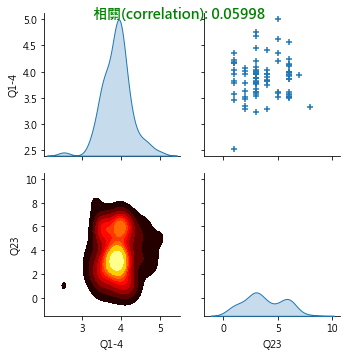

In [151]:
main_path = os.getcwd()
# font = font_manager.FontProperties(fname=r'C:\Windows\Fonts\msyhbd.ttc').get_name()
# matplotlib.rc('font', family=font)

csv_path = os.path.join(main_path, "original_text.csv")
numeric_csv_path = os.path.join(main_path, "original_numeric.csv")

csv_file = pd.read_csv(csv_path)
numeric_csv_file = pd.read_csv(numeric_csv_path)
original_numeric_csv_file = numeric_csv_file.iloc[:, 18:].copy()

question_list = csv_file.iloc[0].to_list()
original_question_list = question_list.copy()
csv_file = csv_file.iloc[5:]

numeric_csv_file, question_list = merge_question_with_part(numeric_csv_file, question_list)
second_merge_csv, second_question_list = second_merge_question(numeric_csv_file.copy(deep=True), question_list.copy())
# display(second_merge_csv)
# numeric_csv_file = numeric_csv_file.iloc[5:]
# numeric_csv_file.to_csv("original_numeric.csv", encoding="utf_8_sig")

# plot_correlation_heatmap(original_numeric_csv_file, "Q15", "Q43", original_question_list)
# plot_correlation_heatmap(numeric_csv_file, "Q15", "Q43", question_list)

# plot_pie_chart(second_merge_csv, second_question_list, "Q1-4")
second_merge_csv["Q1-4"] = 6-second_merge_csv["Q1-4"]
plot_correlation_heatmap(second_merge_csv, "Q1-4", "Q23", second_question_list) # major
# plot_correlation_heatmap(second_merge_csv, "Q1-4", "Q24", second_question_list) # year
# plot_correlation_heatmap(second_merge_csv, "Q1-4", "Q21", second_question_list) # gender

# get_corr_matrix(second_merge_csv, second_question_list)

# cal_corelation(numeric_csv_file, "Q43", "Q15", question_list)
# plot_pie_chart(csv_file, question_list, "Q6")
# csv_file.to_csv("abc.csv", encoding="utf_8_sig")